In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
categorical = ["lead_source","industry","employment_status","location"]
numerical = ["number_of_courses_viewed","annual_income","interaction_count","lead_score"]

df[categorical]= df[categorical].fillna("NA")
df[numerical]= df[numerical].fillna(0.0)

In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']


del df_train['converted']
del df_val['converted']
del df_test['converted']

# Q1

In [6]:
from sklearn.metrics import roc_auc_score

In [7]:
for num_col in numerical:
    auc = roc_auc_score(y_train, df_train[num_col]) 
    print(f"{num_col} importance: {round(auc,3)}")

number_of_courses_viewed importance: 0.764
annual_income importance: 0.552
interaction_count importance: 0.738
lead_score importance: 0.614


# Q2

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [9]:
dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

In [10]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [11]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]
round (roc_auc_score(y_val, y_pred),3)

0.817

# Q3

In [12]:
import numpy as np

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn) )

/tmp/ipykernel_41988/3232938118.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))


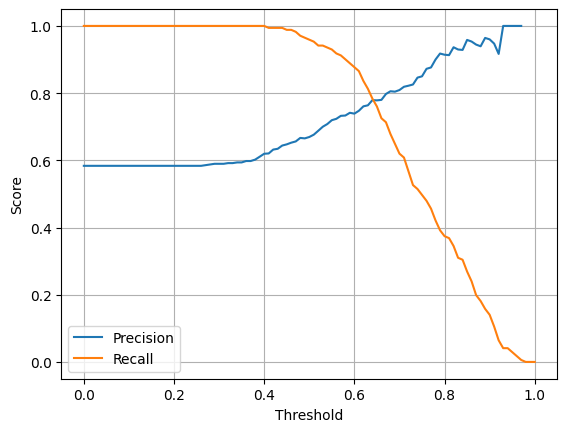

In [13]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Q-4

In [14]:
import numpy as np

thresholds = np.linspace(0, 1, 101)

f1_scores =[]

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p= (tp / (tp + fp) if (tp + fp) > 0 else 0)
    r= (tp / (tp + fn) if (tp + fn) > 0 else 0)
    f1 = 0 if (p + r) == 0 else (2 * p * r) / (p + r)
    f1_scores.append(f1)

In [15]:
f1_scores = np.array(f1_scores)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best F1 =", round(f1_scores[best_idx],3))
print("Best threshold =", (round(best_threshold,3)))

Best F1 = 0.812
Best threshold = 0.57


# Q5

In [17]:
from sklearn.model_selection import KFold

In [18]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [19]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [21]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train["converted"]
    y_val = df_val["converted"]
    
    df_train = df_train.drop(columns=["converted"])
    df_val = df_val.drop(columns=["converted"])

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


In [22]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


# Q6

In [26]:


def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model



In [27]:


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [28]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train["converted"]
        y_val = df_val["converted"]
        
        df_train = df_train.drop(columns=["converted"])
        df_val = df_val.drop(columns=["converted"])

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.561 +- 0.024
C=0.001 0.868 +- 0.019


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

C=1 0.920 +- 0.011
